# Ames Housing Prices

## Purpose of the Analysis:

### Find out which Variables Strongly Affect the Housing Prices

The goal of this project is to determine which variables most strongly correlate to the housing prices in Ames, Iowa. the part sof the notebook is split into the EDA, Feature Engineering, and Modeling where regression will be conducted. Three types of regression will be conducted (Ordinary Least Square, Ridge Regression, and Lasso Regression). The root means squared error will be use to determine the training error, cross validation error, and test error.

The file codebook.txt in the repository gives a description of what each independent variable is in the data.

Some of the ideas presented in this project comes from the Data 200 Course at UC Berkeley. The link to the course is here: http://www.ds100.org/su20/

In [191]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn import linear_model as lm
from sklearn.base import clone

full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

training_data, test_data = train_test_split(full_data, random_state=42, test_size=0.2)

full_data.shape

(2000, 82)

## EDA

First, we will see the amount of missing data in each column and drop those that have too many to the point where it isn't meaningful to analyze them.

In [192]:
nanmean=training_data.isna().mean()*100
nan=nanmean[nanmean>25].sort_values(ascending=False)
print(nan)

training_data.drop(columns=nan.index,inplace=True)

Pool_QC         99.5000
Misc_Feature    96.0000
Alley           93.9375
Fence           80.6250
Fireplace_Qu    48.6875
dtype: float64


C:\Users\bench\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


The joint plot was made to see of there are any outliers. We can see thaat there are two outliers where the living area is greater than 500 sq. ft and one where the sales price is greater than $700,000.

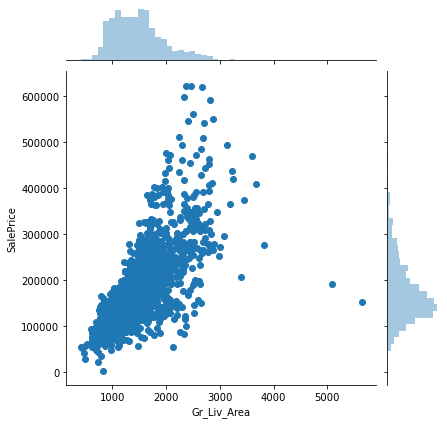

In [193]:
training_data.columns.values

sns.jointplot(
    x='Gr_Liv_Area', 
    y='SalePrice', 
    data=training_data,
);

Upon looking at the data more, the two outliers exist because they were partial sales. Therefore, it is our best interest to remove the outliers to prevent our regression from inaccurately fitting. 

In [194]:
training_data.loc[training_data['Gr_Liv_Area']>5000,['Sale_Condition','SalePrice']]

,Sale_Condition,SalePrice
1471,Partial,190950
1014,Partial,152200


In [195]:
def remove_outliers(data, variable, upper):
    return data.loc[(data[variable] < upper), :]

training_data = remove_outliers(training_data, 'Gr_Liv_Area', 5000)

The type of data in each variable will help determine how we will manipulate the variable.

In [196]:
training_data.dtypes.value_counts()

object     38
int64      30
float64     9
dtype: int64

The distribution of neighborhoods in the data might give us something insightful. We see that most of the houses reside in the Ames area, which is expected.

<AxesSubplot:xlabel='Neighborhood'>

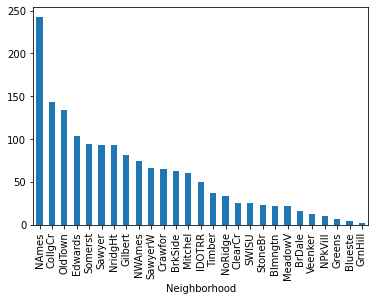

In [197]:
training_data.groupby('Neighborhood').size().sort_values(ascending=False).plot(kind='bar')

The correlation between the Sales Price and the numerical variables will help determine which variables to choose in our linear regression. One thing to keep in mind is colinearity within the data. This will be addressed later in the notebook.

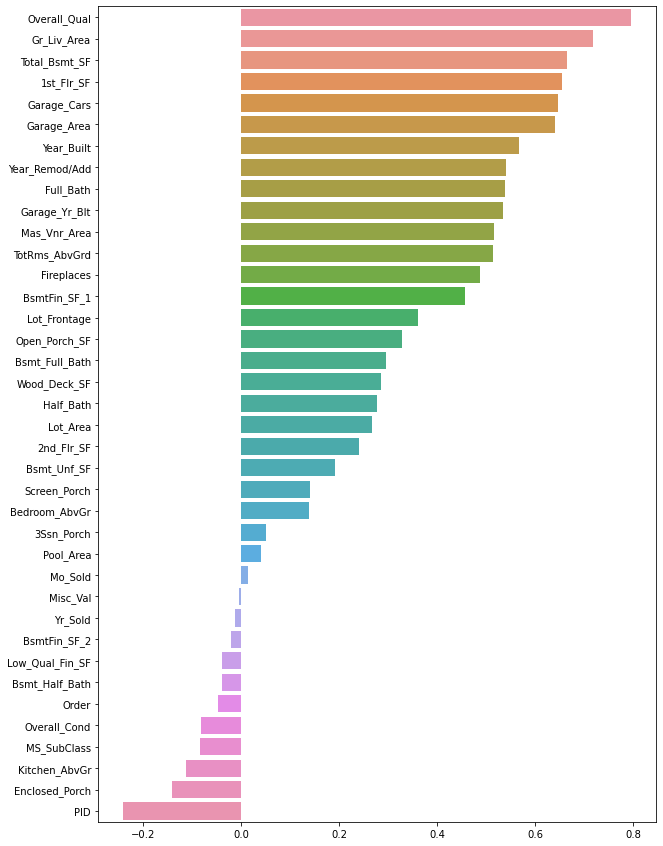

In [198]:
num_cols = training_data.dtypes[(training_data.dtypes == 'int64') | (training_data.dtypes == 'float64')].index
corr_df = training_data.loc[:,num_cols].corr()

sale_price_corr = corr_df['SalePrice'].drop('SalePrice',axis=0).sort_values(ascending=False)
ax = plt.subplots(figsize=(10,15))
ax = sns.barplot(y=sale_price_corr.keys(),x=sale_price_corr.values)

There is some interesting remarks from the barplot. Intuitively, one can expect that if there are more bedrooms, the sale price will be higher. However, from creating a scatter plot, there doesn't seem to be a clear correlation. 

<AxesSubplot:xlabel='Bedroom_AbvGr', ylabel='SalePrice'>

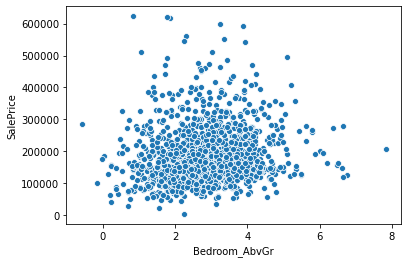

In [199]:
noise = np.random.normal(0,0.5,training_data.shape[0])
training_data_2=training_data
training_data_2['Bedroom_AbvGr']=training_data_2['Bedroom_AbvGr']+noise
sns.scatterplot(data=training_data_2,x='Bedroom_AbvGr',y='SalePrice')

The overall quality of the house (rated 1-10) seemed to have the highest correlation. Let's see how the scatter plot looks like.

<AxesSubplot:xlabel='Overall_Qual', ylabel='SalePrice'>

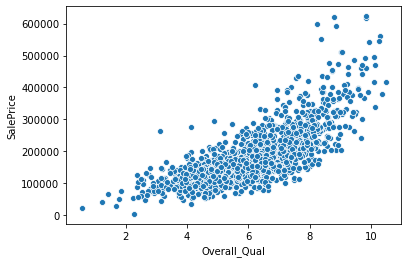

In [200]:
training_data_2=training_data
training_data_2['Overall_Qual']=training_data_2['Overall_Qual']+noise
sns.scatterplot(data=training_data_2,x='Overall_Qual',y='SalePrice')

## Feature Engineering

We will now explore variables where feature engineering is required.

Given the number of variables that show the quantity of bathrooms, we can combine it into a variable with the total number of bathrooms as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

*From Data 100 Notebook

In [201]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms']=with_bathrooms[bath_vars].fillna(0)@weights
    return with_bathrooms

training_data = add_total_bathrooms(training_data)

We can then create a scatter plot that tells us the number of total bathrooms vs the Sale Price and notice that there is a slighty positive correlation.

<AxesSubplot:xlabel='TotalBathrooms', ylabel='SalePrice'>

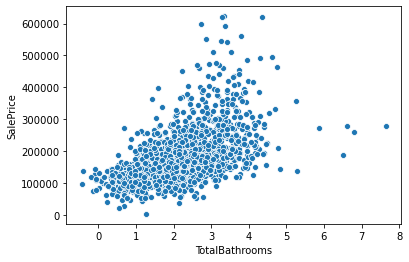

In [202]:
training_data_2=training_data
training_data_2['TotalBathrooms']=training_data_2['TotalBathrooms']+noise
sns.scatterplot(data=training_data_2,x='TotalBathrooms',y='SalePrice')

Next, houses that are in rich neighborhoods are likely to be more expensive. From grouping the data by the neighborhoods, there are four distinct neighborhoods that have the largest sales price, followed by a dropoff. 

* Idea from Data 100 Notebook 

In [203]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    neighborhoods = data.groupby('Neighborhood').agg(metric).sort_values('SalePrice',ascending=False).iloc[0:n].index.tolist()
    return neighborhoods

training_data.groupby('Neighborhood').agg(np.median).sort_values('SalePrice',ascending=False).iloc[0:10]

,Order,PID,MS_SubClass,Lot_Frontage,Lot_Area,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Mas_Vnr_Area,...,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Misc_Val,Mo_Sold,Yr_Sold,SalePrice,TotalBathrooms
Neighborhood,,,,,,,,,,,,,,,,,,,,,
StoneBr,1637.0,527212050.0,60.0,78.5,12438.0,8.554863,5.0,2005.0,2006.0,245.0,...,57.0,0.0,0.0,0.0,0.0,0.0,7.0,2007.0,363500.0,3.055394
NoRidge,1158.0,528348030.0,60.0,91.5,11002.0,7.939486,5.0,1996.0,1997.0,420.0,...,75.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,315600.0,3.287095
NridgHt,1070.0,528150120.0,60.0,93.0,12220.0,8.401051,5.0,2006.0,2006.0,278.0,...,60.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,315100.0,2.960971
GrnHill,2575.0,916252745.0,120.0,NaN,9001.0,7.132605,5.0,1992.0,1992.0,119.5,...,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2006.5,279350.0,2.382605
Veenker,1506.0,533251625.0,40.0,90.0,13268.5,7.359600,5.0,1978.5,1991.5,0.0,...,38.5,0.0,0.0,0.0,0.0,0.0,5.5,2007.5,248250.0,3.084382
Timber,1579.0,916386040.0,20.0,83.0,12633.0,7.282512,5.0,2003.0,2003.0,128.0,...,40.0,0.0,0.0,0.0,0.0,0.0,5.0,2008.0,233600.0,2.775390
Somerst,1477.0,528478550.0,60.0,75.0,8332.0,7.333669,5.0,2006.0,2006.0,60.0,...,87.0,0.0,0.0,0.0,0.0,0.0,6.0,2007.5,227114.0,2.650181
Greens,1217.0,533253065.0,120.0,40.0,3811.0,7.880878,5.0,1980.0,1980.0,0.0,...,78.0,0.0,0.0,0.0,0.0,0.0,6.5,2008.0,211575.0,1.880878
CollgCr,1483.0,907202240.0,20.0,70.0,9920.0,7.058014,5.0,2002.0,2002.0,68.0,...,42.0,0.0,0.0,0.0,0.0,0.0,6.0,2008.0,201300.0,2.576206


The following code will add the feature to the dataset.

In [204]:
def add_in_rich_neighborhood(data, neighborhoods):
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(neighborhoods).astype('category')
    return data

rich_neighborhoods = find_rich_neighborhoods(training_data, 4, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

One Hot Encoding will be used for categorical variables. The following is a function that will one hot encode variables.

In [205]:
def ohe_column(data,column):
    column_ohe=pd.get_dummies(data[column],drop_first=True,prefix=column)
    data=pd.concat([data, column_ohe], axis=1)
    return data

Two categorical variables that I am interested in is how functional is the house and the exterior quality. Both variables will intuitively be correlated to how expensive the house is.

In [206]:
training_data=ohe_column(training_data,'Functional')
training_data=ohe_column(training_data,'Exter_Qual')

To lower the error of our fit, it would be good to see how many variables is optimal to use before the cross-validation error increases (i.e. bias-variance tradeoff).

An algorithm was created to determine the optimal amount of features for our regression model. The following code will only factor in numberical variables. The RMSE is plotted for each addition of a variable.

The plot illustrates that the RMSE decreases up until the 15th feature. After that, the RMSE flattens out and then slightly decreases further. Therefore, choosing 10-15 variables is optimal to lower the RMSE and to prevent a low bias and high variance.

*Borrowed from Data 100*

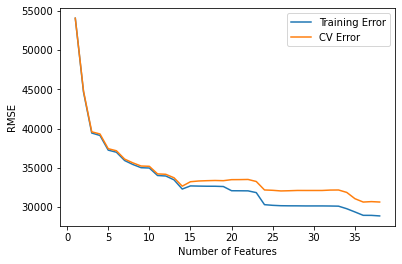

In [207]:
train_error_vs_N = []
cv_error_vs_N = []
linear_model=lm.LinearRegression()
range_of_num_features = range(1, sale_price_corr.shape[0] + 1)

for N in range_of_num_features:
    sale_price_corr_first_N_features = sale_price_corr.iloc[:N]
    saleprice=training_data['SalePrice'].drop(training_data.index[training_data[sale_price_corr.iloc[:N].index].isnull().any(1)])
    indepVar=training_data[sale_price_corr_first_N_features.index].dropna()
    
    cv_results = cross_validate(linear_model, indepVar, saleprice, cv=4,scoring=('r2', 'neg_root_mean_squared_error'),return_train_score=True)
    
    train_error_overfit =-np.mean(cv_results['train_neg_root_mean_squared_error'])
    test_error_overfit=-np.mean(cv_results['test_neg_root_mean_squared_error'])
    train_error_vs_N.append(train_error_overfit)
    cv_error_vs_N.append(test_error_overfit)
    
sns.lineplot(range_of_num_features, train_error_vs_N)
sns.lineplot(range_of_num_features, cv_error_vs_N)
plt.legend(["Training Error", "CV Error"])
plt.xlabel("Number of Features")
plt.ylabel("RMSE");

Further illustration shows exactly where the dip occurs before the RMSE rises again. The valley seems to occur on 14 variables.

In [208]:
print(cv_error_vs_N[10:15])

[34221.39630522602, 34168.10654023762, 33725.436327793934, 32654.314250355346, 33220.646450334476]


From the 14 variables, it is important to take out variables that are dependent on each other. A heat map with the correlation between the variables were made. 

For example, the amount of cars you can fit into a garage is highly correlated to the garage area, which is intuitive. Therefore, we need to delete one of the variables.

<AxesSubplot:>

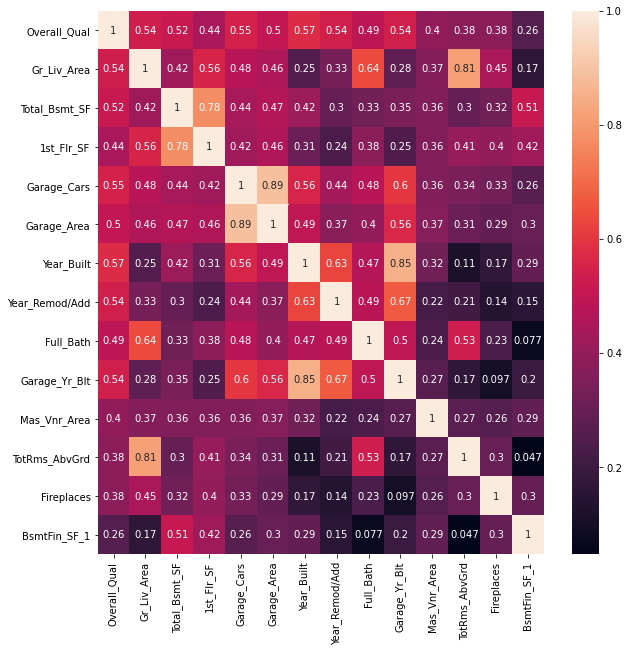

In [209]:
features=sale_price_corr.iloc[:14]

plt.figure(figsize=(10,10))
sns.heatmap(training_data[features.index].corr(),annot=True)

From observing the heat map, there were 5 variables that I decided to take out to minimize multicollinearity.

In [210]:
colinear=['TotRms_AbvGrd','Garage_Area','Year_Remod/Add','Full_Bath','Garage_Yr_Blt']

## Modeling

We will define our pipeline to create the dataframe that will be passed into the regression models.

*Idea from Data 200*

In [211]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual-predicted)**2))

def select_columns(data, columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_fm(data):
    data = remove_outliers(data, 'Gr_Liv_Area', 5000)
    data = add_total_bathrooms(data)
    data=ohe_column(data,'Functional')
    data=ohe_column(data,'Exter_Qual')
    data=data.drop(data[data['Garage_Area'].isnull()].index)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    
    num_features=list(features.drop(colinear).index)
    other_features=['SalePrice', 
                   'TotalBathrooms', 
                   'in_rich_neighborhood',
                   'Exter_Qual_Fa', 
                'Exter_Qual_Gd', 
                'Exter_Qual_TA',
                'Functional_Min1',
                'Functional_Min2',
                'Functional_Mod',
                'Functional_Typ']
    overall_features=num_features+other_features
    
    data = select_columns(data, overall_features)
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    return X, y

### Ordinary Least Square

The first type of regression that will be conducted is the ordinary least square. 

The data will be read in again and if there is no data in any of the 14 numerical columns we chose, we will remove it.

The data will be split into the test and training data.

In [212]:
full_data = pd.read_csv('https://raw.githubusercontent.com/benchang123/Ames-Housing/master/ames.csv')

num_features=list(features.drop(colinear).index)
full_clean=full_data.drop(full_data.index[full_data[num_features].isnull().any(1)])

training_data, test_data = train_test_split(full_clean, random_state=42, test_size=0.25)

It seems like only 19 rows were removed, which isn't bad.

In [213]:
full_clean.shape

(1981, 82)

Both the training and test data will be processed into our pipeline that we defined earlier.

In [214]:
X_train,y_train=process_data_fm(training_data)
X_test,y_test=process_data_fm(test_data)

The training data will be fit into our linear regression model and out of that, the predicted training and test sales prices will be determined.

In [215]:
final_model = lm.LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_train = final_model.predict(X_train)
y_predicted_test = final_model.predict(X_test)

The RMSE of the test and training dataset will be calculated.

In [216]:
training_rmse = rmse(y_predicted_train, y_train)
test_rmse = rmse(y_predicted_test, y_test)
(training_rmse,test_rmse)

(28543.249494000094, 29072.495020763417)

A residual plot of the RMSE and Predicted Sales Price shows that in general the regression was fine except for predicted sales price greater than 40,000, where there is a large absolute RMSE.

Text(0, 0.5, 'RMSE')

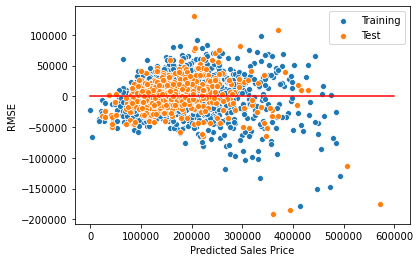

In [217]:
ax=sns.scatterplot(y_predicted_train,y_predicted_train-y_train,label="Training")
ax=sns.scatterplot(y_predicted_test,y_predicted_test-y_test,label="Test")
sns.lineplot([0,600000],0,color='red')

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

The predicted and actual sales price for the test dataset is plotted. There are a few outliers above the true sales price of 500,000.

Text(0, 0.5, 'Actual Sales Price')

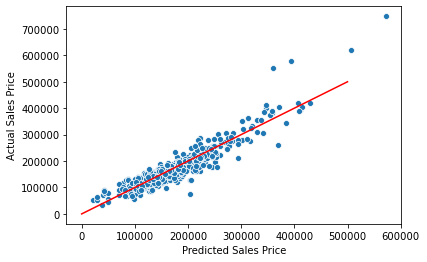

In [218]:
sns.scatterplot(y_predicted_test,y_test)
sns.lineplot([0,500000],[0,500000],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

### Ridge Regression

The second type of regression that will be implemented is the ridge regression. Since the regularization parameter depends on the coefficents of our regression, the data has to be standardized to prevent one feature from being overrepresented.

In [219]:
from sklearn import preprocessing

X_train_n,y_train_n=process_data_fm(training_data)
X_test_n,y_test_n=process_data_fm(test_data)

X_train_n = preprocessing.scale(X_train_n)
X_test_n = preprocessing.scale(X_test_n)

y_train_n=(y_train-np.mean(y_train))/np.std(y_train)
y_test_n=(y_test-np.mean(y_test))/np.std(y_test)

First, the optimal hyperparameter needs to be found for the regression.

In [220]:
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
final_ridge = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
final_ridge.fit(X_train_n, y_train_n)
alpha = final_ridge.best_params_['alpha']
alpha

5.0

From determining best alpha, we can further refine the searching on what the best alpha should be.

In [221]:
param_gridimp = {'alpha': list(np.linspace(1,10,200))}
final_ridgeimp = GridSearchCV(lm.Ridge(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
final_ridgeimp.fit(X_train_n, y_train_n)
alphaimp = final_ridgeimp.best_params_['alpha']
round(alphaimp,2)

3.58

The predicted sales price can then be determined.

In [222]:
y_ridge_train = final_ridgeimp.predict(X_train_n)
y_ridge_test = final_ridgeimp.predict(X_test_n)

A residual plot was then made. Here we can see that the same issue as the ordinary least squares regression where at around 2.1, there is a large absolute RMSE. 

Text(0, 0.5, 'RMSE')

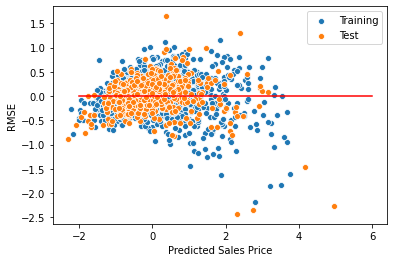

In [223]:
ax=sns.scatterplot(y_ridge_train,y_ridge_train-y_train_n,label="Training")
ax=sns.scatterplot(y_ridge_test,y_ridge_test-y_test_n,label="Test")
sns.lineplot([-2,6],0,color='red')

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

The same shows in our scatter plot of the predicted and actual sales price. There are four clear outliers where the sales price was underestimated.

Text(0, 0.5, 'Actual Sales Price')

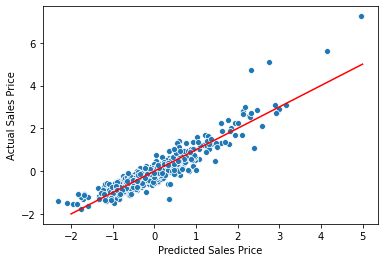

In [224]:
sns.scatterplot(y_ridge_test,y_test_n)
sns.lineplot([-2,5],[-2,5],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

### Lasso Regression

The third type of regression that will be implemented is the lasso regression. We will use the standardized data for the same reason as the ridge regression.

In [225]:
param_grid = {'alpha': [0.01, 0.1, 1., 5., 10., 25., 50., 100.]}
final_lasso = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_grid, scoring='neg_mean_squared_error')
final_lasso.fit(X_train_n, y_train_n)
alpha = final_lasso.best_params_['alpha']
round(alpha,2)

0.01

Oddly, we see that the lack of a hyperparameter is optimal for the lasso regression.

In [226]:
param_gridimp = {'alpha': list(np.linspace(0.005,0.1,100))}
final_lassoimp = GridSearchCV(lm.Lasso(), cv=5, param_grid=param_gridimp, scoring='neg_mean_squared_error')
final_lassoimp.fit(X_train_n, y_train_n)
alphaimp = final_lassoimp.best_params_['alpha']
round(alphaimp,2)

0.0

The predicted sales price is then determined.

In [227]:
final_lassoimp.fit(X_train_n, y_train_n)
y_lasso_train = final_lassoimp.predict(X_train_n)
y_lasso_test = final_lassoimp.predict(X_test_n)

A residual plot was then made and the same pattern is seen as the ridge regression.

Text(0, 0.5, 'RMSE')

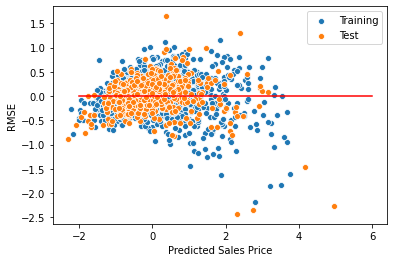

In [228]:
sns.lineplot([-2,6],0,color='red')
ax=sns.scatterplot(y_ridge_train,y_ridge_train-y_train_n,label="Training")
ax=sns.scatterplot(y_ridge_test,y_ridge_test-y_test_n,label="Test")

plt.legend(labels=['Training', 'Test'])
leg = ax.legend()
plt.xlabel('Predicted Sales Price')
plt.ylabel('RMSE')

The same pattern shows in our scatter plot as the ridge regression where there are four clear outliers where the sales price was underestimated.

Text(0, 0.5, 'Actual Sales Price')

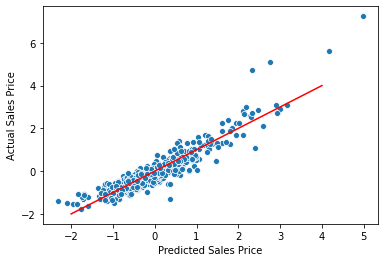

In [229]:
sns.scatterplot(y_ridge_test,y_test_n)
sns.lineplot([-2,4],[-2,4],color='red')

plt.xlabel('Predicted Sales Price')
plt.ylabel('Actual Sales Price')

# Conclusion

In the end, we determined that using 9 numberical variables was optimal for our regression. A few categorical variables were added that would intuitively correlate to the sales price.

Areas of improvement including trying to find a method that determines the best categorical variables to use, as only two were used in this notebook. This will help fit our data better to the model and reduce test errors.